# Subsampling analysis

Here, we analysed of effect of varying how often a species is represented in the database using three species with high numbers of plasmids in the NCBI-database, namely Escherichia coli, Klebsiella pneumoniae and Salmonella enterica.

First, we created three base databases - basically corresponding to the NCBI-database but excluding the plasmids from Escherichia coli, Klebsiella pneumoniae and Salmonella enterica, respectively, from the `HyAsP create` commands.

Next, we subsampled the available plasmids of the three species multiple times at different levels (i.e. number of plasmids) and added the genes of the subsampled plasmids to the corresponding base database.
 - Escherichia coli: 259 plasmids
 - Klebsiella pneumoniae: 184 plasmids
 - Salmonella enterica: 157 plasmids
 - other species: 5215 plasmids
 
Note that these numbers vary slightly from table S13 in the supplement because some of the necessary GenBank files were broken (could not be downloaded properly).
Using a level increment of 20 for all three species, they were sampled at 12, 9 respectively 7 intermediate levels, with 3 repetitions per level.

Subsequently, HyAsP was evaluated in terms of precision, recall and F1 score (union version) using the resulting subsampling databases on the test samples of the respective species.
In addition, we evaluated HyAsP using the base databases and the full database (also including the genes from the plasmids of  three species).

**Observation:**
For all three species, precision and recall across the test samples varied the most for no or only a few plasmids of the respective species but were already quite good scores on some samples when relying (mostly) on genes from other species. 
Increasing the number of plasmids, in general, led to an increased recall and F1 score, while the precision decreased (but only very slightly). Salmonella enterica was the species that relied the least on adding explicitly adding genes from plasmids of that species and should already very high scores when using only genes from other species.

Overall, the three evaluations indicated that it is possible to detect plasmids even when the gene database is built with no or only smaller numbers of plasmids from that species, while adding plasmids from the species of interest is still beneficial.

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random

pd.options.display.max_rows = None

In [3]:
def parse_structure(filename):
    with open(filename) as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            # number of reference chromosomes:
            if line.startswith('number of reference c'):
                skip_ref_chromosomes = i + 1
                continue
                
            # number of reference plasmids:
            if line.startswith('number of reference p'):
                skip_ref_plasmids = i + 1
                continue
                
            # number of predicted plasmids:
            if line.startswith('number of p'):
                skip_pred_plasmids = i + 1
                continue
            
            # > predicted plasmid covers <proportion> of reference plasmid
            if line.startswith('> pr'):
                skip_ref_by_pred = i + 1
                continue
            
            # > reference plasmid covers <proportion> of predicted plasmid
            if line.startswith('> r'):
                skip_pred_by_ref = i + 1
                continue
                
            # > in total, how much of predicted plasmid is covered by reference plasmids
            if line.startswith('> in total, how much of p'):
                skip_pred_by_all = i + 1
                continue
                
            # > in total, how much of reference plasmid is covered by predicted plasmids
            if line.startswith('> in total, how much of r'):
                skip_ref_by_all = i + 1
                continue
            
            # > pairs of predicted and reference plasmids with coverage >= ... in both directions
            if line.startswith('> pa'):
                skip_mutual = i + 1
                continue
            
            # > summary scores
            if line.startswith('> s'):
                skip_summary_scores = i + 1
                break
        
        return skip_ref_chromosomes, skip_ref_plasmids, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, \
                skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores

def read_table(file, skip_rows, num_rows, h = 0, s = '\t', col_sums = False, renaming = {}):
    df = pd.read_csv(file, skiprows = skip_rows, nrows = num_rows, sep = s, header = h)
    if col_sums:
        df.loc[len(df.index)] = ['Total'] + list(df.drop(df.columns[0], axis = 1).sum())
    df.rename(columns = renaming, inplace = True)
    return df

def list_plasmids(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'plasmid', 1: 'length (nt)'})
    df.plasmid = [v[1:-1] for v in df.plasmid]
    return df[['plasmid', 'length (nt)']]

def list_scores(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'score', 1: 'value'})
    df['score'] = [v[:-1].replace('score_ref_coverage', 'recall').replace('score_pred_coverage', 'precision').replace('overall_score', 'overall') for v in df['score']]
    return df


def read_scores(org, list_file, ids_file, increment, repetitions):
    num_gb_files = 0
    with open(list_file, 'r') as in_file:
            for line in in_file:
                num_gb_files += 1
    levels = [0] + list(range(increment, num_gb_files, increment)) + [num_gb_files]
    
    sample_ids = []
    with open(ids_file, 'r') as in_file:
        for line in in_file:
            sample_ids.append(int(line.strip()))

    scores_per_sample = []

    for sid in sample_ids:
        for level in levels:
            for rep in range(0, repetitions):
                if (level == 0 or level == levels[-1]) and rep > 0:
                    pass
                else:
                    eval_file = 'subsamples/%s/results/sample_%i/%i_%i/greedy_eval.csv' % (org, sid, level, rep)

                    # reference information
                    _, skip_ref_plasmids, skip_pred_plasmids, _, _, _, _, _, _ = parse_structure(eval_file)
                    num_ref_plasmids = skip_pred_plasmids - skip_ref_plasmids - 3

                    total_length_refs = list_plasmids(eval_file, skip_ref_plasmids, num_ref_plasmids)['length (nt)'].sum()

                    if os.path.isfile(eval_file): 
                        _, _, skip_pred_plasmids, skip_ref_by_pred, _, _, _, _, skip_summary_scores = parse_structure(eval_file)
                        num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2

                        total_length_preds = list_plasmids(eval_file, skip_pred_plasmids, num_pred_plasmids)['length (nt)'].sum()
                        scores = list_scores(eval_file, skip_summary_scores, 3)
                        recall = scores.iloc[0]['value']
                        precision = scores.iloc[1]['value']
                        f1_score = scores.iloc[2]['value']

                        recalled_nt = int(recall * total_length_refs)
                        precise_nt = int(precision * total_length_preds)
                    else:
                        total_length_preds = 0
                        recall = 0
                        precision = 0
                        f1_score = 0
                        recalled_nt = 0
                        precise_nt = 0

                    scores_per_sample.append([sid, level, rep, int(total_length_refs), int(total_length_preds), 
                                              int(recalled_nt), int(precise_nt), recall, precision, f1_score])


    return pd.DataFrame(scores_per_sample, columns = ['sample', 'level', 'repetition', 'total_length_refs', 
                                                      'total_length_preds', 'recalled_nt', 'precise_nt', 
                                                      'Recall', 'Precision', 'F1 score'])

def aggregate(scores_per_sample):
    aggregated_scores = []
    level_rep_groups = scores_per_sample.groupby('level')
    for level_rep, group in level_rep_groups:
        total_precision = group['precise_nt'].sum() / group['total_length_preds'].sum()
        total_recall = group['recalled_nt'].sum() / group['total_length_refs'].sum()
        total_f1_score = 2 * (total_recall * total_precision) / (total_recall + total_precision) if total_recall + total_precision > 0 else 0
        aggregated_scores.append([level_rep, total_precision, total_recall, total_f1_score])
    return pd.DataFrame(aggregated_scores, columns = ['Level', 'Precision', 'Recall', 'F1 score'])

In [4]:
def create_plot(name, list_file, increment, repetitions, out_dir):
    gb_files = []
    with open(list_file, 'r') as in_file:
        for line in in_file:
            gb_files.append(line.strip())


    rows = [0] + list(range(increment, len(gb_files), increment)) + [len(gb_files)]
    columns = ['Precision', 'Recall', 'F1 score']

    fig, axes = plt.subplots(nrows = len(rows), ncols = len(columns), figsize = (20,30), sharey = True)

    for i in range(0, len(rows)):
        for j in range(0, len(columns)):
            for r in range(0, repetitions):
                if (i == 0 or i == (len(rows) - 1)) and r > 0:
                    pass # only one repetition for zero and all plasmids
                else:
                    results_file = '%s/scoring_results_%i_%i.csv' % (out_dir, rows[i], r)
                    df = pd.read_csv(results_file, sep = ';', header = None)
                    df.columns = ['tool', 'sample_id', 'Recall', 'Precision', 'F1 score']
                    df = df.loc[df['tool'] == 'greedy_putative']
                    pos = [i + random.uniform(-0.2, 0.2) for i in range(0, len(df['sample_id']))]
                    axes[i][j].scatter(pos, df[columns[j]])
                    axes[i][j].set_xlabel('sample_id')
                    axes[i][j].set_xticks(range(0, len(df['sample_id'])))
                    axes[i][j].set_xticklabels(df['sample_id'])
                    axes[i][j].set_xlabel('')
                    axes[i][j].set_ylim([-0.1, 1.1])


    for j in range(0, len(columns)):
        axes[0][j].set_title(columns[j], fontsize = 20)
        axes[-1][j].set_xlabel('Sample id', fontsize = 20)

    for i in range(0, len(rows)):
        axes[i][0].set_ylabel('Scores,\n%s plasmids' % rows[i], fontsize = 20)

    plt.tight_layout()
    
    plt.savefig('%s.eps' % name, format = 'eps', dpi = 1200, bbox_inches = 'tight')
    plt.savefig('%s.pdf' % name, format = 'pdf', dpi = 1200, bbox_inches = 'tight')
    #plt.savefig('%s.png' % name, format = 'png', dpi = 1200, bbox_inches = 'tight')

## Escherichia coli

In [5]:
org = 'escherichia'
ids_file = 'escherichia_ids.txt'
list_file = 'support_files/escherichia/gb_file_list.txt'
increment = 20
repetitions = 3
subsamples_dir = 'subsamples/escherichia'
name = 'subsampling_escherichia'

In [6]:
scores_per_sample = read_scores(org, list_file, ids_file, increment, repetitions)
aggregate(scores_per_sample)

,Level,Precision,Recall,F1 score
0,0,0.811435,0.699311,0.751212
1,20,0.798938,0.764407,0.781291
2,40,0.804875,0.809895,0.807377
3,60,0.816325,0.832581,0.824373
4,80,0.818782,0.821281,0.820029
5,100,0.800585,0.859972,0.829217
6,120,0.816738,0.875609,0.845150
7,140,0.816118,0.861270,0.838086
8,160,0.806001,0.882766,0.842639
9,180,0.811098,0.905945,0.855902


The aggregated scores for the intermediate subsampling levels sum over all repetitions.

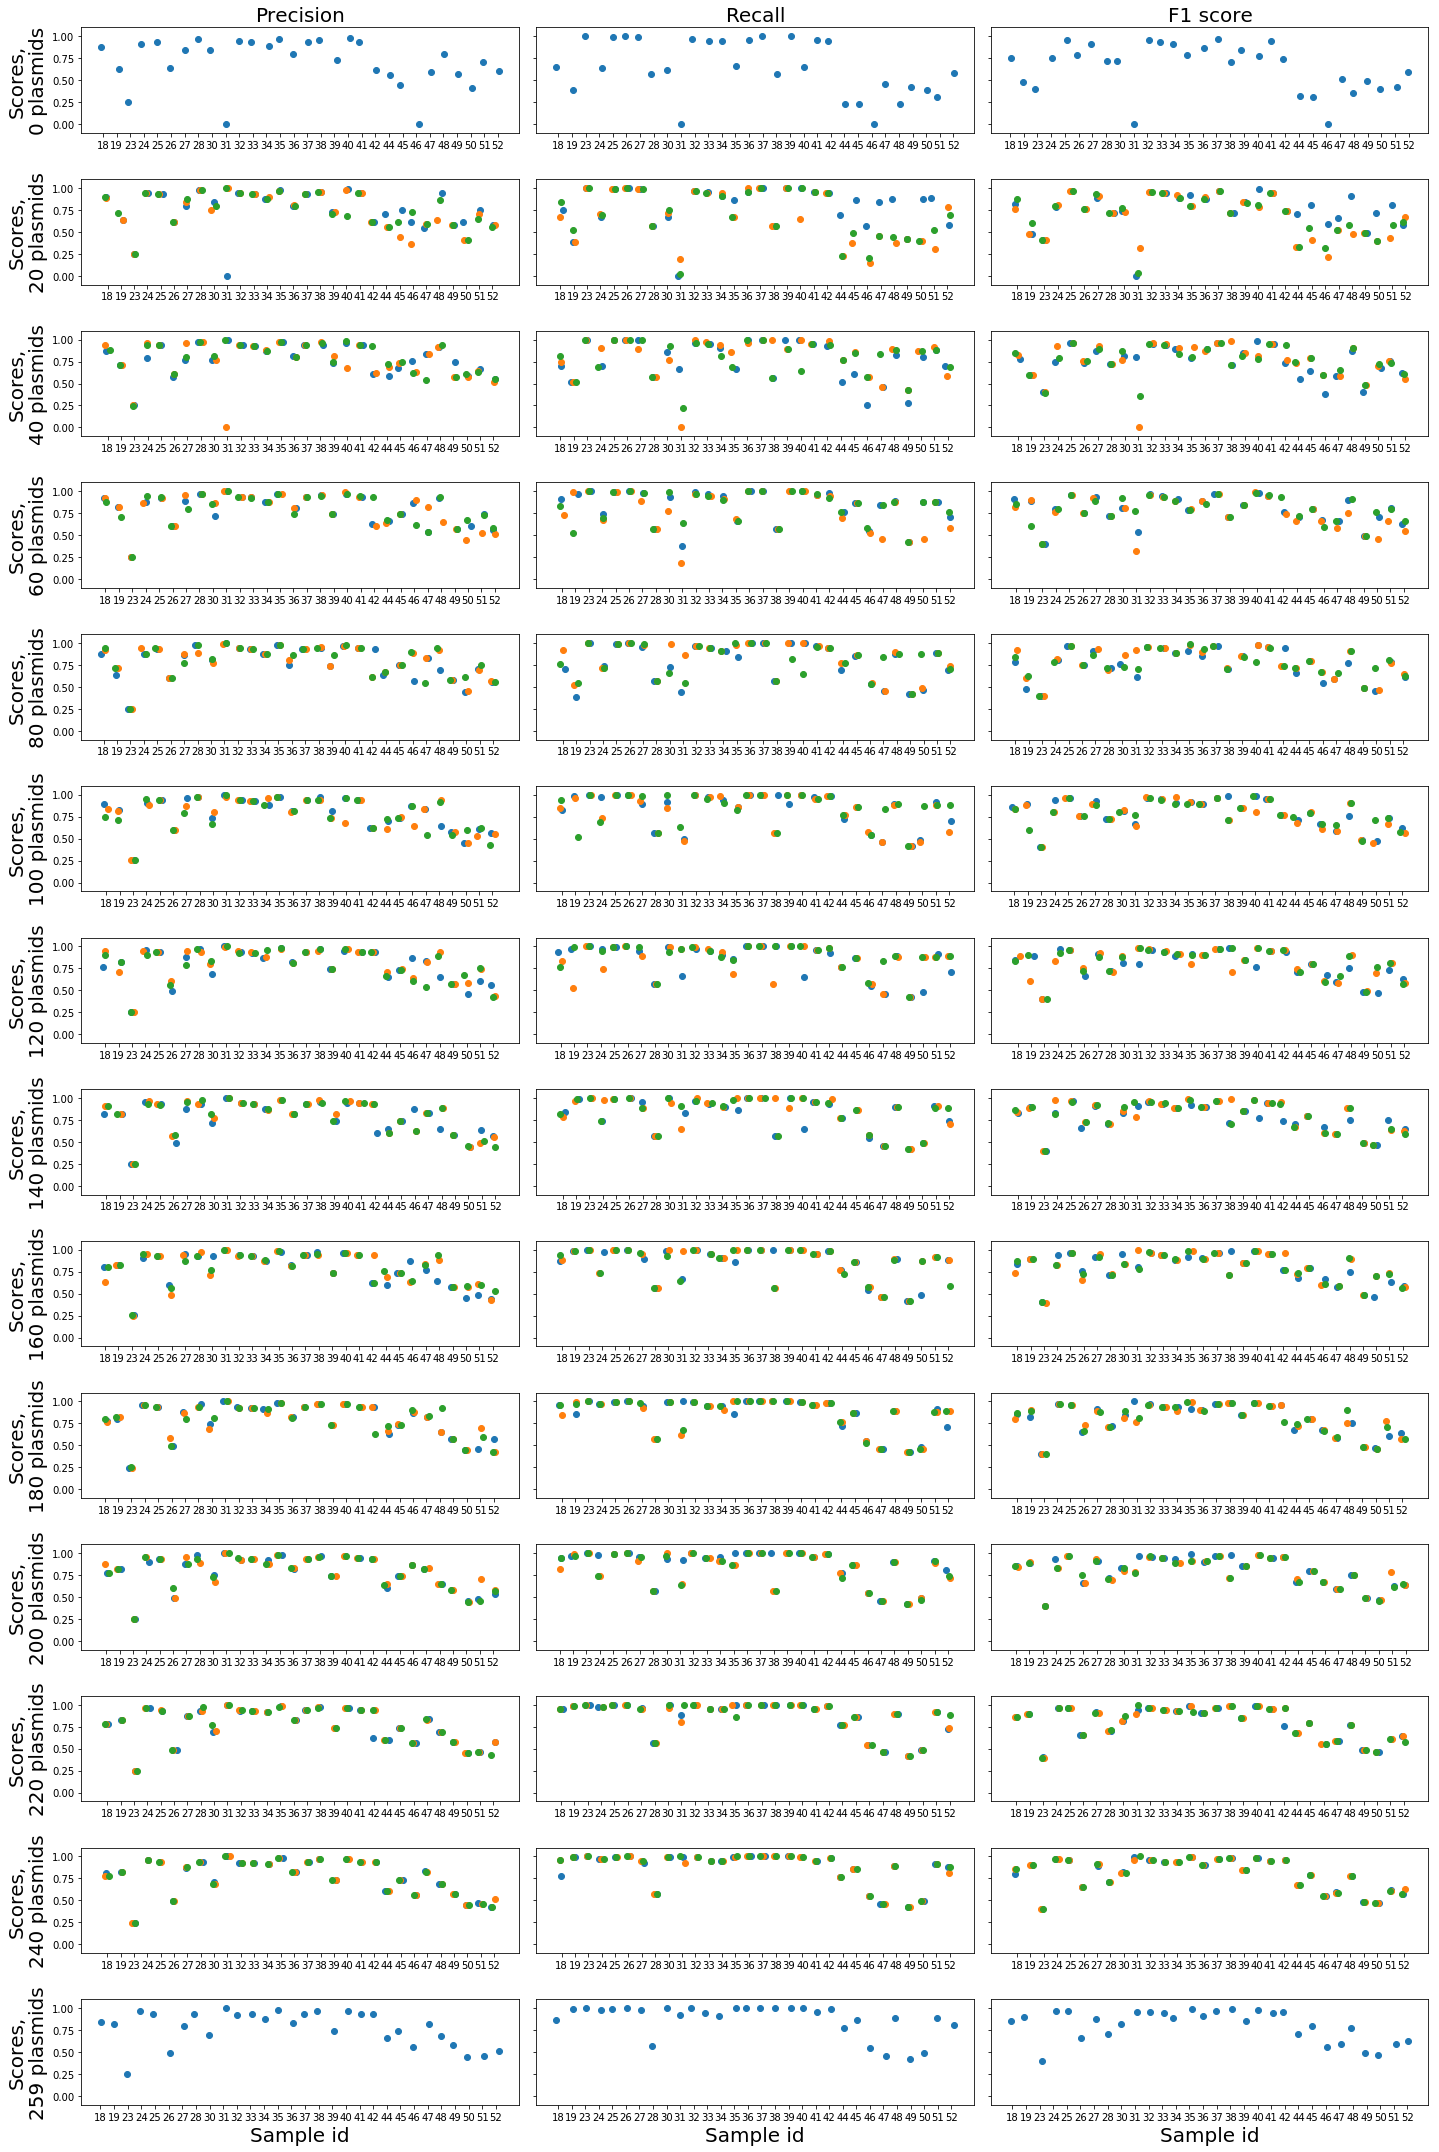

In [7]:
create_plot(name, list_file, increment, repetitions, subsamples_dir)

## Klebsiella pneumoniae

In [8]:
org = 'klebsiella'
ids_file = 'klebsiella_ids.txt'
list_file = 'support_files/klebsiella/gb_file_list.txt'
increment = 20
repetitions = 3
subsamples_dir = 'subsamples/klebsiella'
name = 'subsampling_klebsiella'

In [9]:
scores_per_sample = read_scores(org, list_file, ids_file, increment, repetitions)
aggregate(scores_per_sample)

,Level,Precision,Recall,F1 score
0,0,0.921148,0.661584,0.770082
1,20,0.897656,0.703747,0.788961
2,40,0.871274,0.861328,0.866272
3,60,0.852932,0.824185,0.838312
4,80,0.897296,0.859748,0.878121
5,100,0.897765,0.898773,0.898269
6,120,0.883196,0.903150,0.893062
7,140,0.864925,0.901730,0.882944
8,160,0.856313,0.910822,0.882727
9,180,0.852564,0.915275,0.882807


The aggregated scores for the intermediate subsampling levels sum over all repetitions.

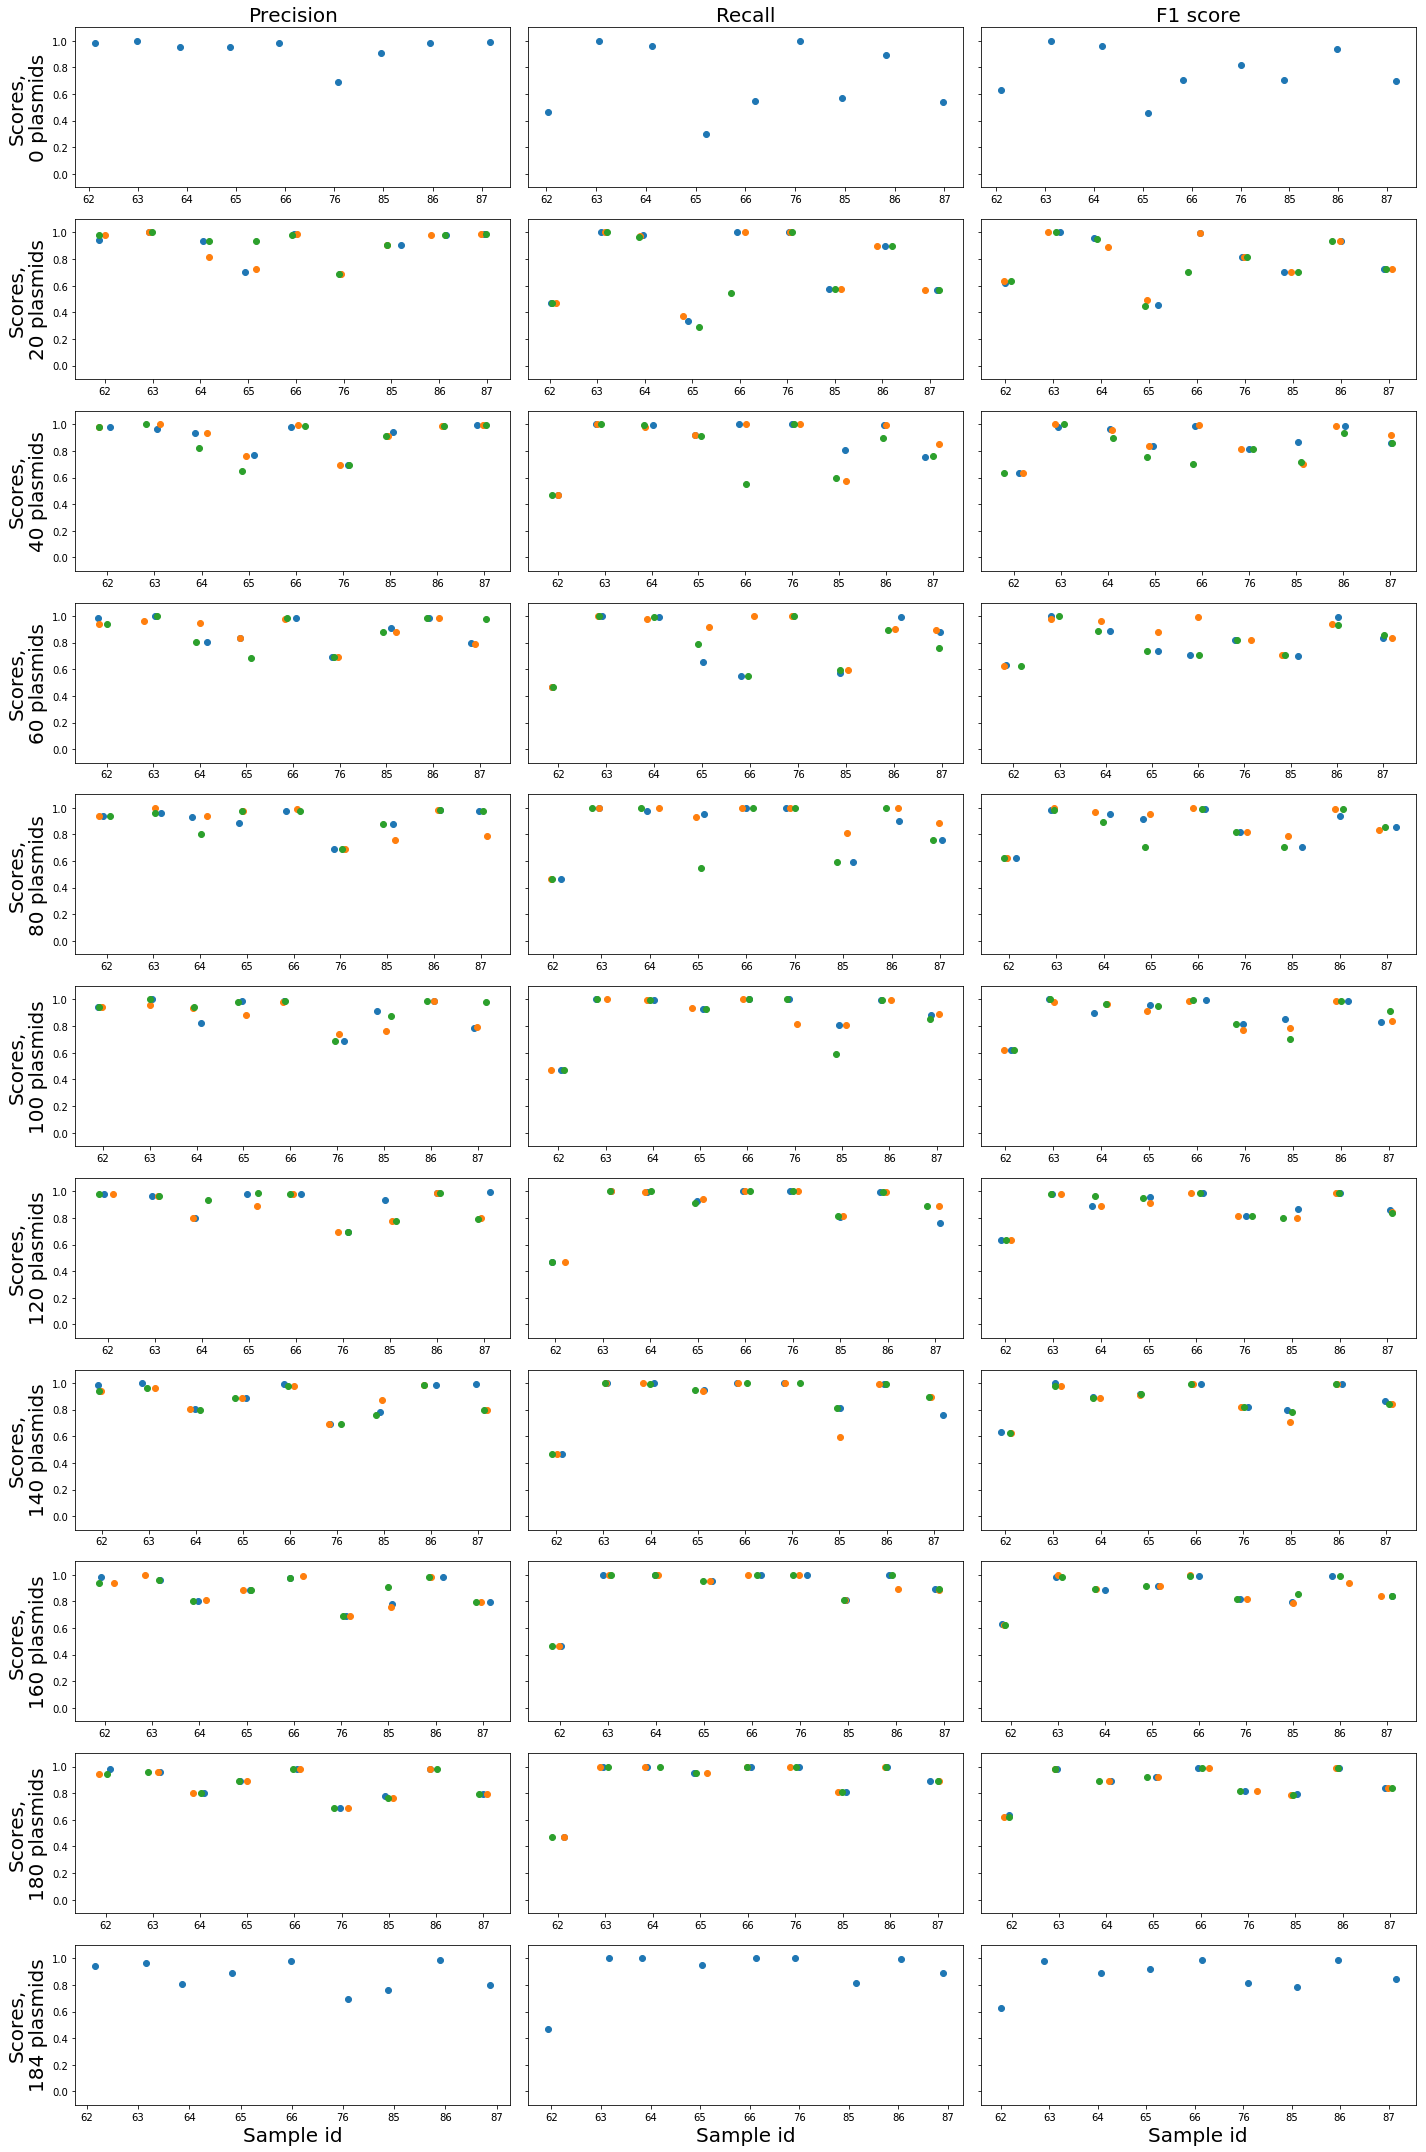

In [10]:
create_plot(name, list_file, increment, repetitions, subsamples_dir)

## Salmonella enterica

In [11]:
org = 'salmonella'
ids_file = 'salmonella_ids.txt'
list_file = 'support_files/salmonella/gb_file_list.txt'
increment = 20
repetitions = 3
subsamples_dir = 'subsamples/salmonella'
name = 'subsampling_salmonella'

In [12]:
scores_per_sample = read_scores(org, list_file, ids_file, increment, repetitions)
aggregate(scores_per_sample)

,Level,Precision,Recall,F1 score
0,0,0.986155,0.871714,0.925410
1,20,0.986389,0.889124,0.935234
2,40,0.986400,0.889979,0.935712
3,60,0.986378,0.888269,0.934756
4,80,0.986615,0.906534,0.944881
5,100,0.986400,0.889979,0.935712
6,120,0.986834,0.923943,0.954353
7,140,0.986823,0.923088,0.953892
8,157,0.986834,0.923943,0.954353


The aggregated scores for the intermediate subsampling levels sum over all repetitions.

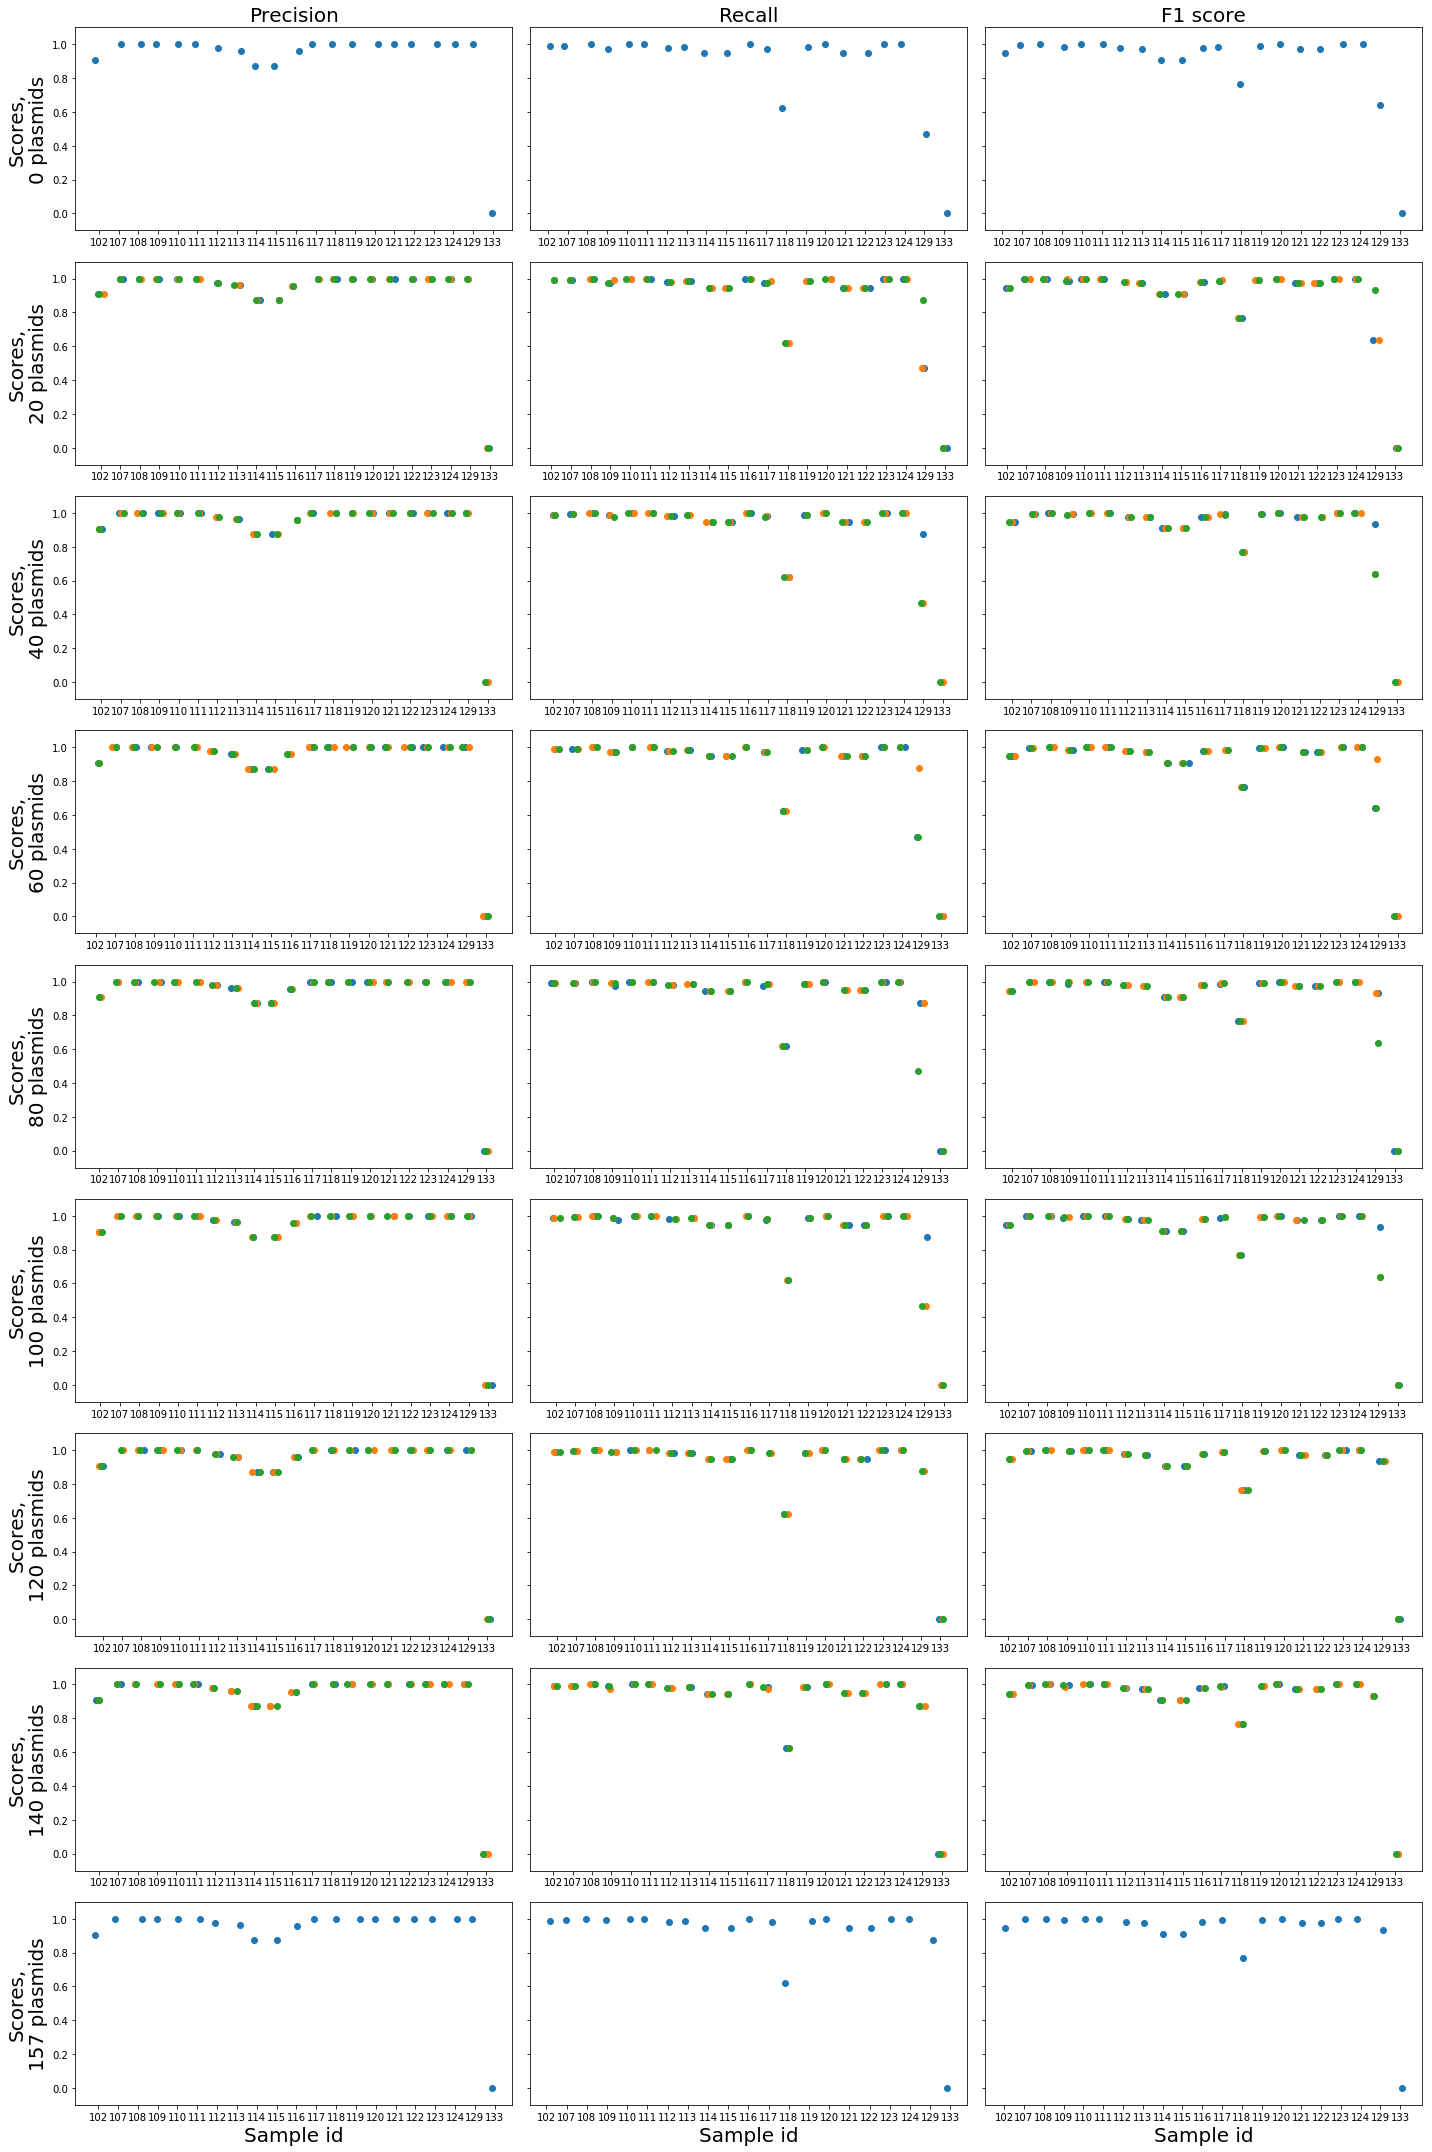

In [13]:
create_plot(name, list_file, increment, repetitions, subsamples_dir)